In [1]:
#/usr/bin/env python
import numpy as np
import pylab as pl
import subprocess as sp
#import source_redshift_dist as srd
import healpy as hp
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value
import input
import os
from scipy.integrate import quad
from scipy.interpolate import interp1d
import healsparse
import random

H0 = 71.0
Om0=0.2648
Ob0=0.044792699861138666
ncosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Ob0=Ob0)

rho_crit = ncosmo.critical_density0.to(u.solMass/u.Mpc/u.Mpc/u.Mpc).value/ncosmo.h/ncosmo.h #M_sun Mpc^-3 *h*h
vc = 2.998e5 #km/s
G = 4.3011790220362e-09 # Mpc/h (Msun/h)^-1 (km/s)^2
mp      = 2.602746*10**9*ncosmo.h                                   # in Msun/h

#From Cyrille: 2602746430.321433


########################### Mass Maps ################################
path_out = 'IA-infusion/HACC-Y1/kappa/'
path_in = '/global/cscratch1/sd/xuod/HOS_sims/L845/HACC150/shells_z106_subsampleauto_groupiso/'
directory_contents = os.listdir(path_in)




In [2]:
def total_area(x_in,y_in):
    x_down = x_in[:-1]
    x_up = x_in[1:]
    y_down = y_in[:-1]
    y_up = y_in[1:]

    area_array = (y_down+y_up)*(x_up-x_down)/2.0

    return np.sum(area_array)


def cal_pdz(fname, z_in,col):

    #zs,dist1 = np.loadtxt("./data/source_distribution.txt",comments='#',usecols=(0,1),unpack=True)
    zs,dist1 = np.loadtxt(fname,comments='#',usecols=(0,col),unpack=True)
    dist1_normal = dist1/total_area(zs,dist1)
    # dist1_normal = dist1

    #np.savetxt("./data/srd_normed.dat",np.transpose(np.array([zs,dist1_normal])),fmt="%.6e")

    # f1 = interp1d(zs[::-1], dist1_normal[::-1], kind='cubic',bounds_error=False, fill_value=0.0)
    f1 = interp1d(zs[::-1], dist1_normal[::-1], kind='linear',bounds_error=False, fill_value=0.0)
    #f1 = interp1d(zs, dist1_normal, kind='linear',fill_value="extrapolate")

    return f1(z_in)

def wfunc_all(fname, zl,col):
    
    if(zl==0):
        zl=0.0001
        print("set minimal zl to 0.0001")
    Dc_l = ncosmo.comoving_distance(zl).value*ncosmo.h
    cfactor = 4.0*np.pi*G/vc**2*(1.0+zl)/Dc_l


    zs_list = np.linspace(0.001,4.0,1000)
    #zs_list = np.logspace(-3,0.6,100)
    dzs = zs_list[1]-zs_list[0]
    total_wfunc = 0.0

    for zs in zs_list:
        if (zs<zl):
            continue

        Dc_s = ncosmo.comoving_distance(zs).value*ncosmo.h
        Dc_ls = Dc_s - Dc_l

        tmp = dzs*cal_pdz(fname, zs,col)*Dc_ls/Dc_s
        total_wfunc = total_wfunc + tmp

    #res = cfactor/afactor*total_wfunc
    res = cfactor*total_wfunc

    return res

def kappa_sl_ss(filename,zl,zs):

    if(zl==0):
        zl=0.0001
        print("set minimal zl to 0.0001")

    Dc_l = ncosmo.comoving_distance(zl).value*ncosmo.h
    Dc_s = ncosmo.comoving_distance(zs).value*ncosmo.h
    Dc_ls = Dc_s - Dc_l

    nside_c = 32
    a = healsparse.HealSparseMap.read(os.path.join(path, filename))
    sdens = a.generate_healpix_map()

    # turn masked pixels to zero.
    sdens[sdens<-1.0e+30]=0
    #Map already in ring format:

    
    
    sdens_arc = sdens#/np.deg2rad(1.0)**2.0#*3.0462e-4 # 1 degree^2 = 3.0462e-4 steradian
    sdens_arc*=mp
    sdens_arc_normal = (sdens_arc-sdens_arc.mean()*8.0) # factor of 8.0 corrects for mean computed over all 8 octants

    #Normalisation:
    Norm = 1.6125e+07

    
    #-----------------------
    # Results 2
    cfactor = 4.0*np.pi*G/vc**2
    res = cfactor*(1.0+zl)/Dc_l*Dc_ls/Dc_s*sdens_arc_normal*Norm
    #print('Kernel = ', zl, zs, cfactor*(1.0+zl)/Dc_l*Dc_ls/Dc_s)
    return res

def kappa_sl_ms(filename,fname,zl,col):

    nside_c = 32    
    a = healsparse.HealSparseMap.read(os.path.join(path, filename))
    sdens = a.generate_healpix_map()
    
    # turn masked pixels to zero.
    sdens[sdens<-1.0e+30]=0
    #Map already in ring format:
    #hp.mollview(sdens,
    #            unit='kappa', cmap=pl.cm.coolwarm,
    #            cbar=True, title='', norm=None
    #            , nest=False
    #            )
    #pl.show()
    
    
    
    sdens_arc = sdens#/np.deg2rad(1.0)**2.0#*3.0462e-4 # 1 degree^2 = 3.0462e-4 steradian
    sdens_arc*=mp
    sdens_arc_normal = (sdens_arc-sdens_arc.mean()*8.0) # factor of 8.0 corrects for mean computed over all 8 octants

    #Normalisation:
    Norm = 1.6125e+07
    
    res = wfunc_all(fname, zl,col)*sdens_arc_normal*Norm

    print(filename, zl, mp, wfunc_all(fname, zl,col))
    #hp.mollview(res,
    #            unit='kappa_z', cmap=pl.cm.coolwarm,
    #            cbar=True, title='', norm=None
    #            , nest=False
    #            )
    #pl.show()

    return res



In [3]:
# Set redshift arrays:
#zfile=np.loadtxt("z2ts.txt",delimiter=',')
nshells=106
seed=0
IC=150

zfile=np.loadtxt("z2ts_HACCY1_"+str(nshells)+".txt")
snaplist = zfile[0:nshells,0].astype(int)
zsnap=zfile[0:nshells,1]
print(snaplist[0:nshells])
#print(zsnap)
rds_lower = zfile[0:nshells,2]
rds_upper  = zfile[0:nshells,3]


   
#-----
# Get lens redshifts, either from geometry (Wrong, I miss the dNdz.):
zl_list = (3.0/4.0)*(rds_upper**4-rds_lower**4)/(rds_upper**3-rds_lower**3)
#... or from the partice distribution:
#tmp=np.loadtxt("z_or_skysim.txt")
zlens_exact=np.zeros_like(zsnap)
for plane in range(0,nshells):
    #zlens_exact[plane]=zsnap[nshells-1-plane]
    zlens_exact[plane]=zsnap[plane]
zlens_exact = zlens_exact[:nshells] 
    
print( " z_       z^               zl_geo             zl_file            "  )
for plane in range(0,nshells):
    print(rds_lower[plane], rds_upper[plane], zl_list[plane],zlens_exact[plane] )

#Mean_r = (r_max^4 - r_min^4)/(r_max^3 - rmin^3)*(3/4)
#zl_list = 0.5*(rds_lower+rds_upper)


#print(zlens_exact)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105]
 z_       z^               zl_geo             zl_file            
0.0 0.00600601 0.004504507499999999 0.0
0.00600601 0.01823708 0.014017602733857612 0.01208459
0.01823708 0.02971312 0.02487347666696408 0.02446483
0.02971312 0.04253112 0.036872329582454955 0.03501545
0.04253112 0.05567227 0.04968438084292224 0.05015674
0.05567227 0.06801276 0.06225157564881571 0.06124604
0.06801276 0.08064517 0.07468592454678327 0.07486631
0.08064517 0.09357998 0.08743208967807324 0.08648649
0.09357998 0.1068282 0.10049559512736292 0.1007667
0.1068282 0.12040134 0.1138847044982096

set minimal zl to 0.0001
Got lens 0.0
[-0.00017318 -0.00017318 -0.00017318 ... -0.00017318 -0.00017318
 -0.00017318]
Reading in weight map for Mira Titan (Comment if already on disk...)


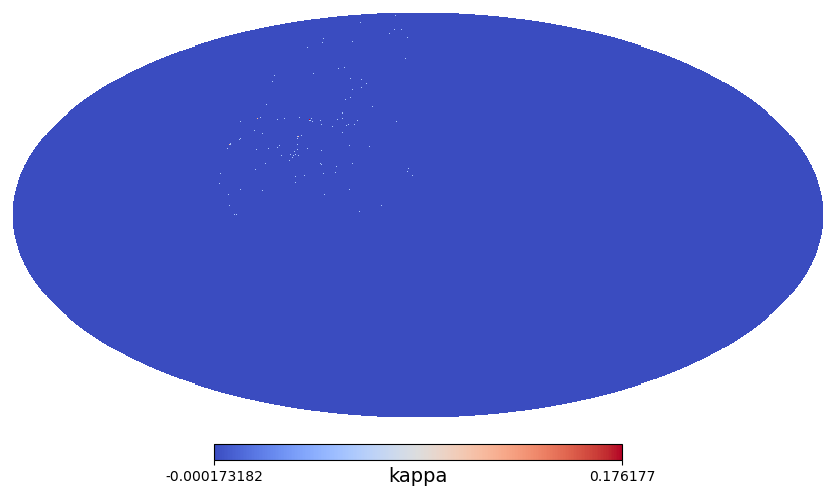

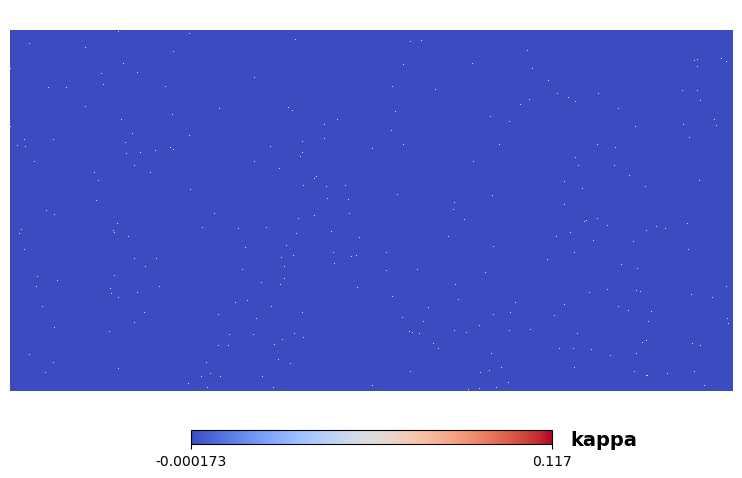

/tmp/ipykernel_31642/4246586392.py:90: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fname = '../../../HACC-Y1/kappa/V0/IC'+str(IC)+'/seed'+str(seed)+"/"+np.str("{:5.4f}".format(zs))+"kappa"


Saved kappa
set minimal zl to 0.0001
Got lens 0.0
[-0.00017515 -0.00017515 -0.00017515 ... -0.00017515 -0.00017515
 -0.00017515]
Got lens 0.01208459
[-0.00019274 -0.00019274 -0.00019274 ... -0.00019274 -0.00019274
 -0.00019274]
Mask already defined!


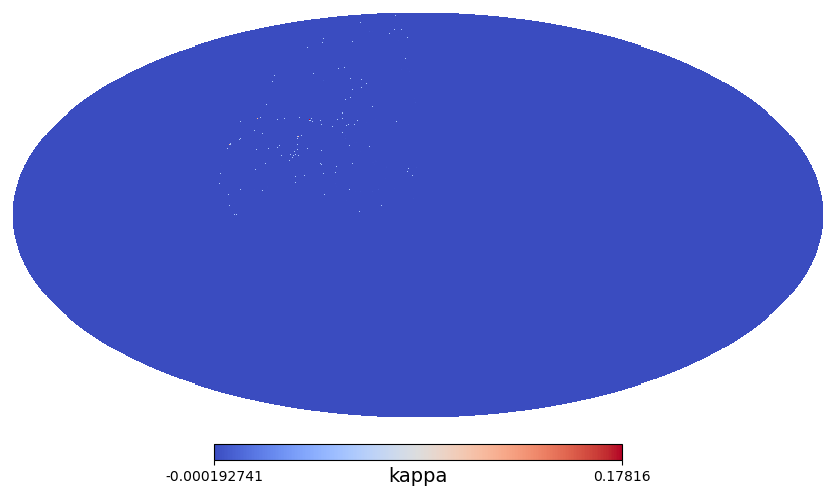

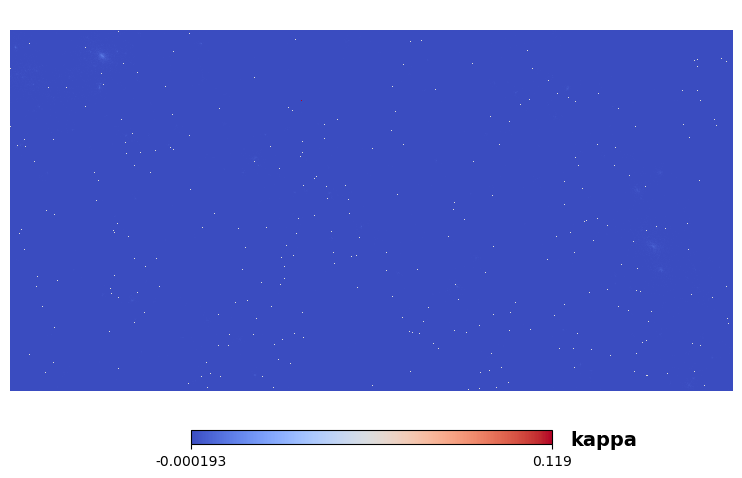

Saved kappa
set minimal zl to 0.0001
Got lens 0.0
[-0.00017552 -0.00017552 -0.00017552 ... -0.00017552 -0.00017552
 -0.00017552]
Got lens 0.01208459
[-0.00020646 -0.00020646 -0.00020646 ... -0.00020646 -0.00020646
 -0.00020646]
Got lens 0.02446483
[-0.00022232 -0.00022232 -0.00022232 ... -0.00022232 -0.00022232
 -0.00022232]
Mask already defined!


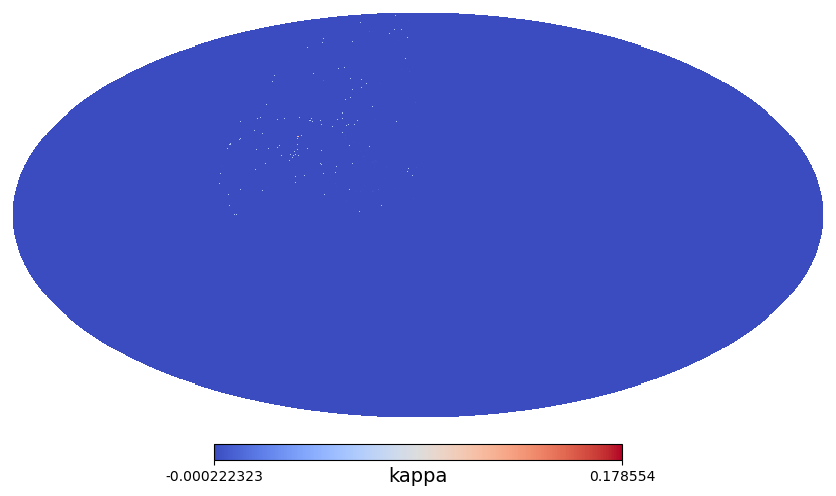

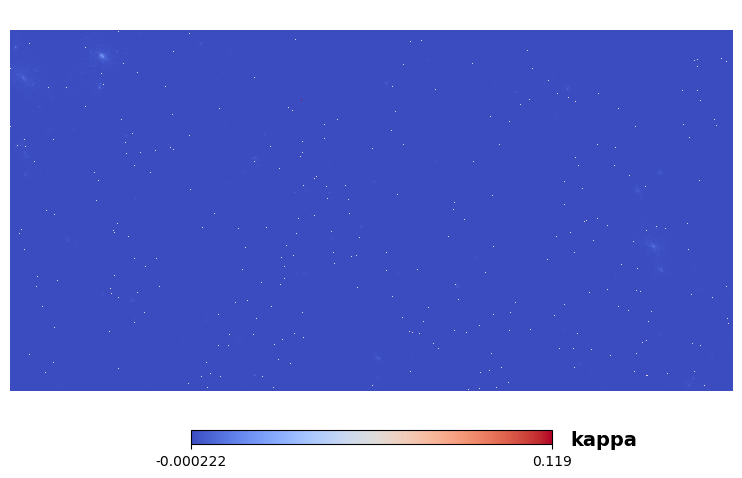

Saved kappa
set minimal zl to 0.0001


KeyboardInterrupt: 

In [4]:
# Mass2Kappa_zslice
# For n(z) see further below;


#if __name__ == '__main__':
#
nside = 4096
npix = 12 * nside**2
noct = npix / 8 - nside

seed=2
IC=150
path = '/global/cscratch1/sd/xuod/HOS_sims/L845/HACC'+str(IC)+'/'


# Start loop over source redshifts

#for zs in zsnap[1:]:
for zs in rds_upper[0:nshells]:



    # Initialise kappa maps:
    kpmap = np.zeros(npix)
    
        
    #planeIndexes = dlup[:,0]<=zs
    #planeIndexes = np.flip(zlens_exact)<=zs
    #print(zs,planeIndexes)
    
    for lens in range(0,nshells):
        zl=zlens_exact[lens]

        if zl >= zs:          
            continue
      
        filename= 'shells_z'+str(nshells)+'_subsampleauto_groupiso/shell_hacc_z'+str(lens)+'_nside4096_seed'+str(seed)+'.fits'
        #print(zs, zl)
        #print(filename, lens, zl, zs)
            
        kappa_z = kappa_sl_ss(path+filename, zl, zs)
        kpmap = kpmap + kappa_z
        print("Got lens " +str(zl))
        print(kpmap)
    # Convert to ring-ordered for sph.harmonic transforms:
    #kpmap_ring = hp.reorder(kpmap, n2r = True)
    #print("reordered map")

    #Apply mask
    if 'hpmap_weight' in locals():
        print("Mask already defined!")
    else:
        print("Reading in weight map for Mira Titan (Comment if already on disk...)")
        #hpmap_weight = hp.fitsfunc.read_map('./IA-infusion/SkySim5000/FullSky_weight.fits', field=0,nest=False, partial=False, hdu=1, h=False, verbose=True, memmap=True)
        hpmap_weight = hp.fitsfunc.read_map('../../FullSky_weight_4096.fits', field=0,nest=False, partial=False, hdu=1, h=False, verbose=True, memmap=True)

    # show mask:
    #hp.mollview(hpmap_weight,
    #            unit=None, cmap=pl.cm.coolwarm,
    #            cbar=True, title='weight', norm=None
    #            , nest=False
    #            )
    #pl.show()

    kpmap *= hpmap_weight
    #print("applied mask")

    # show kappa:
    #np.max(kpmap_ring)
    hp.mollview(kpmap,
                unit='kappa', cmap=pl.cm.coolwarm,
                cbar=True, title='', norm=None
                , nest=False
                )
    pl.show()

    lonra = [0, 20]
    latra = [0, 10]

    hp.cartview(kpmap,
                cbar=True, lonra=lonra, latra=latra,
                nest=False,
                title=" ",
                # min=-10, max=0,
                cmap=pl.cm.coolwarm,
                norm=None, unit='kappa')
    pl.show()
    
    # save to file:
    fname = '../../../HACC-Y1/kappa/V0/IC'+str(IC)+'/seed'+str(seed)+"/"+np.str("{:5.4f}".format(zs))+"kappa"

    np.save(fname, kpmap)
    print("Saved kappa")

In [11]:
np.shape(tmp)

(58,)

In [ ]:
# Compute C_ell:
for zs in zsnap[28:]:

    print( "\nLoading convergence map and computing C_ell's: zs={:5.4f}\n".format(zs) )
    fname = input.kappaDir+np.str("{:5.4f}".format(zs))+"kappa.npy"
    kpmap_ring = np.load(fname)
    print("loaded kappa")

    # Compute C_ell:
    Cl = hp.sphtfunc.anafast(kpmap_ring, map2=None, nspec=None, lmax=5000, mmax=None, iter=1, alm=False, pol=False, use_weights=False, datapath=None, gal_cut=0, use_pixel_weights=False)
    Cl *= 8.0
    print("Got C_ell")
    fname = input.kappaDir+np.str("{:5.4f}".format(zs))+"Cl.dat"
    np.savetxt(fname,Cl)
    print("Saved C_ell")
    



Loading convergence map and computing C_ell's: zs=1.0060

loaded kappa
Got C_ell
Saved C_ell

Loading convergence map and computing C_ell's: zs=1.0552

loaded kappa
Got C_ell
Saved C_ell

Loading convergence map and computing C_ell's: zs=1.1069

loaded kappa
Got C_ell
Saved C_ell

Loading convergence map and computing C_ell's: zs=1.1520

loaded kappa
Got C_ell
Saved C_ell

Loading convergence map and computing C_ell's: zs=1.2088

loaded kappa


In [ ]:
# kappa2shear:

nside = 4096
npix = 12 * nside**2
noct = npix / 8 - nside
seed=1
#IC=150


#for zs in zsnap[0:1]:
#for zs in zsnap[28:29]:
for zs in rds_upper[0:nshells]:
#for zs in rds_upper[0:1]:

    print( "\nLoading convergence map and computing shear maps for zs={:5.4f}\n".format(zs) )
    fname = '../../../HACC-Y1/kappa/V0/IC'+str(IC)+'/seed'+str(seed)+"/"+np.str("{:5.4f}".format(zs))+"kappa.npy"
    kpmap_ring = np.load(fname)
    print("loaded kappa")

    # Compute shear:
    print("starting kappa map2alm")
    #alm_E = hp.sphtfunc.map2alm(kpmap_ring, lmax=5000, mmax=None, iter=3, pol=False, use_weights=False, datapath=None)
    alm_E = hp.sphtfunc.map2alm(kpmap_ring, lmax=8192, mmax=None, iter=3, pol=False, use_weights=False, datapath=None)

    #alm_E = hp.sphtfunc.map2alm(hpmap, lmax=20000, mmax=None, iter=3, pol=False, use_weights=False, datapath=None)
    #alm_E = hp.sphtfunc.map2alm(hpmap_ring, lmax=5000, mmax=None, iter=3, pol=False, use_weights=False, datapath=None)
    #alm_T = alm_E*0.0;
    alm_B = alm_E*0.0;
    #
    print("Starting shear alm2map")
    #maps_QU = hp.alm2map_spin((alm_E, alm_B), nside, spin=2,lmax=5000,mmax=None)
    maps_QU = hp.alm2map_spin((alm_E, alm_B), nside, spin=2,lmax=8192,mmax=None)

    
    #maps_TQU = hp.sphtfunc.alm2map((alm_T, alm_E, alm_B), nside, lmax=32768, mmax=None, pixwin=True, fwhm=0.0, sigma=None, pol=True, inplace=False, verbose=True)
    #maps_TQU = hp.sphtfunc.alm2map((alm_T, alm_E, alm_B), nside, lmax=20000, mmax=None, pixwin=True, fwhm=0.0, sigma=None, pol=True, inplace=False, verbose=True)
    #maps_TQU = hp.sphtfunc.alm2map((alm_T, alm_E, alm_B), nside, lmax=20000, mmax=None, pixwin=False, fwhm=0.0, sigma=None, pol=True, inplace=False, verbose=True)
    #
    gamma1 = maps_QU[0]
    gamma2 = maps_QU[1]
    print("Got shear")
    fname1 = '../../../HACC-Y1/shear/V0/IC'+str(IC)+'/seed'+str(seed)+"/"+np.str("{:5.4f}".format(zs))+"gamma1"
    fname2 = '../../../HACC-Y1/shear/V0/IC'+str(IC)+'/seed'+str(seed)+"/"+np.str("{:5.4f}".format(zs))+"gamma2"

    #fname1 = input.shearDir+np.str("{:5.4f}".format(zs))+"gamma1"
    #fname2 = input.shearDir+np.str("{:5.4f}".format(zs))+"gamma2"
    np.save(fname1, gamma1)
    np.save(fname2, gamma2)
    print("Saved gamma")
    
    # show kappa:
    #np.max(kpmap_ring)
    #hp.mollview(kpmap_ring,
    #            unit='kappa', cmap=pl.cm.coolwarm,
    #            cbar=True, title='', norm=None
    #            , nest=False
    #            )
    #pl.show()

    #lonra = [0, 20]
    #latra = [0, 10]

    #hp.cartview(kpmap_ring,
    #            cbar=True, lonra=lonra, latra=latra,
    #            nest=False,
    #            title=" ",
    #            # min=-10, max=0,
    #            cmap=pl.cm.coolwarm,
    #            norm=None, unit='kappa')
    #pl.show()
    #
    # show gamma1:
    #np.max(kpmap_ring)
    #hp.mollview(gamma1,
    #            unit='gamma1', cmap=pl.cm.coolwarm,
    #            cbar=True, title='', norm=None
    #            , nest=False
    #            )
    #pl.show()

    #hp.cartview(gamma1,
    #            cbar=True, lonra=lonra, latra=latra,
    #            nest=False,
    #            title=" ",
    #            # min=-10, max=0,
    #            cmap=pl.cm.coolwarm,
    #            norm=None, unit='shear1')
    #pl.show()
    # show kappa:
    #np.max(kpmap_ring)
    #hp.mollview(gamma2,
    #            unit='gamma2', cmap=pl.cm.coolwarm,
    #            cbar=True, title='', norm=None
    #            , nest=False
    #            )
    #pl.show()

    #lonra = [0, 20]
    #latra = [0, 10]

    #hp.cartview(gamma2,
    #            cbar=True, lonra=lonra, latra=latra,
    #            nest=False,
     #           title=" ",
    #            # min=-10, max=0,
     #           cmap=pl.cm.coolwarm,
      #          norm=None, unit='shear2')
    #pl.show()


Loading convergence map and computing shear maps for zs=0.0060



/tmp/ipykernel_59398/1217151609.py:16: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fname = '../../../HACC-Y1/kappa/V0/IC'+str(IC)+'/seed'+str(seed)+"/"+np.str("{:5.4f}".format(zs))+"kappa.npy"


loaded kappa
starting kappa map2alm
Starting shear alm2map
Got shear


/tmp/ipykernel_59398/1217151609.py:42: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fname1 = '../../../HACC-Y1/shear/V0/IC'+str(IC)+'/seed'+str(seed)+"/"+np.str("{:5.4f}".format(zs))+"gamma1"
/tmp/ipykernel_59398/1217151609.py:43: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fname2 = '../../../HACC-Y1/shear/V0/IC'+str(IC)+'/seed'+str(seed)+"/"+np.str("{:

Saved gamma

Loading convergence map and computing shear maps for zs=0.0182

loaded kappa
starting kappa map2alm
Starting shear alm2map
Got shear
Saved gamma

Loading convergence map and computing shear maps for zs=0.0297

loaded kappa
starting kappa map2alm
Starting shear alm2map
Got shear
Saved gamma

Loading convergence map and computing shear maps for zs=0.0425

loaded kappa
starting kappa map2alm
Starting shear alm2map
Got shear
Saved gamma

Loading convergence map and computing shear maps for zs=0.0557

loaded kappa
starting kappa map2alm
Starting shear alm2map
Got shear
Saved gamma

Loading convergence map and computing shear maps for zs=0.0680

loaded kappa
starting kappa map2alm


In [4]:
# Mass2Kappa_n(z)
nside = 4096
npix = 12 * nside**2
noct = npix / 8 - nside

#nshells=19
seed=0
IC=150
path = '/global/cscratch1/sd/xuod/HOS_sims/L845/HACC'+str(IC)+'/'


#input_dir = input.baseDirectory
#mapsNames = sorted(directory_contents)[58:1:-1] # use this one when there is a README file in the directory.
#mapsNames = sorted(directory_contents)[57:0:-1]

#mapsNames = np.array(mapsNames)
#print("Found these maps in the directory:", mapsNames)
#print("Found a total of ",np.shape(mapsNames), "Maps")
#print("*****")


# Start loop over source redshifts

for tomo in range(1,6):
    
    print("Working on tomo", tomo)
    # Initialise kappa maps:
    kpmap = np.zeros(npix)
    zid=0

    for lens in range(0,nshells):
        zl=zlens_exact[zid]
        
        filename= 'shells_z'+str(nshells)+'_subsampleauto_groupiso/shell_hacc_z'+str(lens)+'_nside4096_seed'+str(seed)+'.fits'
        print(filename, lens, zl, zid)

        kappa_z = kappa_sl_ms(path+filename,"./Euclid_dndz_fu08_bin1-5.dat",zl,tomo)
        kpmap = kpmap + kappa_z
        print("Got lens " +str(zl))
        print(kappa_z)
        zid+=1
        #hp.cartview(kpmap,
        #        cbar=True, lonra=lonra, latra=latra,
        #        nest=False,
        #        title=" ",
        #        # min=-10, max=0,
        #        cmap=pl.cm.coolwarm,
        #        norm=None, unit='kappa')
        #pl.show()

    #Map already in ring format, no need to re-order

    #Apply mask
    if 'hpmap_weight' in locals():
        print("Mask already defined!")
    else:
        print("Reading in weight map for Mira Titan (Comment if already on disk...)")
        #hpmap_weight = hp.fitsfunc.read_map('../../FullSky_weight.fits', field=0,nest=False, partial=False, hdu=1, h=False, verbose=True, memmap=True)
        hpmap_weight = hp.fitsfunc.read_map('../../FullSky_weight_4096.fits', field=0,nest=False, partial=False, hdu=1, h=False, verbose=True, memmap=True)

    # show mask:
    #hp.mollview(hpmap_weight,
    #            unit=None, cmap=pl.cm.coolwarm,
    #            cbar=True, title='weight', norm=None
    #            , nest=False
    #            )
    #pl.show()

    kpmap *= hpmap_weight
    print("applied mask")

    # show kappa:
    #np.max(kpmap_ring)
    #hp.mollview(kpmap,
    #            unit='kappa', cmap=pl.cm.coolwarm,
    #            cbar=True, title='', norm=None
    #            , nest=False
    #            )
    #pl.show()

    #lonra = [0, 20]
    #latra = [0, 10]

    #hp.cartview(kpmap,
    #            cbar=True, lonra=lonra, latra=latra,
    #            nest=False,
    #            title=" ",
    #            # min=-10, max=0,
    #            cmap=pl.cm.coolwarm,
    #            norm=None, unit='kappa')
    #pl.show()
    
    # save to file, in .npy format:
    #fname = input.kappaDir+"kappa_tomo"+np.str(tomo)
    fname = "../../../HACC-Y1/kappa/V0/IC"+str(IC)+"/seed"+str(seed)+"/kappa_tomo"+np.str(tomo)+"_"+np.str(nshells)

    np.save(fname, kpmap)
    print("Saved kappa")


Working on tomo 1
shells_z106_subsampleauto_groupiso/shell_hacc_z0_nside4096_seed0.fits 0 0.0 0
set minimal zl to 0.0001
set minimal zl to 0.0001
/global/cscratch1/sd/xuod/HOS_sims/L845/HACC150/shells_z106_subsampleauto_groupiso/shell_hacc_z0_nside4096_seed0.fits 0.0 1847949660.0 2.0071505174235283e-18
Got lens 0.0
[0. 0. 0. ... 0. 0. 0.]
shells_z106_subsampleauto_groupiso/shell_hacc_z1_nside4096_seed0.fits 1 0.01208459 1
/global/cscratch1/sd/xuod/HOS_sims/L845/HACC150/shells_z106_subsampleauto_groupiso/shell_hacc_z1_nside4096_seed0.fits 0.01208459 1847949660.0 1.5683624597428945e-20
Got lens 0.01208459
[-3.35273001e-07 -3.35273001e-07 -3.35273001e-07 ... -3.35273001e-07
 -3.35273001e-07 -3.35273001e-07]
shells_z106_subsampleauto_groupiso/shell_hacc_z2_nside4096_seed0.fits 2 0.02446483 2
/global/cscratch1/sd/xuod/HOS_sims/L845/HACC150/shells_z106_subsampleauto_groupiso/shell_hacc_z2_nside4096_seed0.fits 0.02446483 1847949660.0 7.315444074354129e-21
Got lens 0.02446483
[-4.64334397e-05 

applied mask


/tmp/ipykernel_8258/1703849833.py:95: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fname = "../../../HACC-Y1/kappa/V0/IC"+str(IC)+"/seed"+str(seed)+"/kappa_tomo"+np.str(tomo)+"_"+np.str(nshells)


Saved kappa
Working on tomo 2
shells_z106_subsampleauto_groupiso/shell_hacc_z0_nside4096_seed0.fits 0 0.0 0
set minimal zl to 0.0001
set minimal zl to 0.0001
/global/cscratch1/sd/xuod/HOS_sims/L845/HACC150/shells_z106_subsampleauto_groupiso/shell_hacc_z0_nside4096_seed0.fits 0.0 1847949660.0 2.0040619783655155e-18
Got lens 0.0
[0. 0. 0. ... 0. 0. 0.]
shells_z106_subsampleauto_groupiso/shell_hacc_z1_nside4096_seed0.fits 1 0.01208459 1
/global/cscratch1/sd/xuod/HOS_sims/L845/HACC150/shells_z106_subsampleauto_groupiso/shell_hacc_z1_nside4096_seed0.fits 0.01208459 1847949660.0 1.643254542881409e-20
Got lens 0.01208459
[-3.5128288e-07 -3.5128288e-07 -3.5128288e-07 ... -3.5128288e-07
 -3.5128288e-07 -3.5128288e-07]
shells_z106_subsampleauto_groupiso/shell_hacc_z2_nside4096_seed0.fits 2 0.02446483 2
/global/cscratch1/sd/xuod/HOS_sims/L845/HACC150/shells_z106_subsampleauto_groupiso/shell_hacc_z2_nside4096_seed0.fits 0.02446483 1847949660.0 8.035832441408787e-21
Got lens 0.02446483
[-5.10059728

In [5]:
# Compute C_ell:
for tomo in range(1,6):

    print( "\nLoading convergence map and computing C_ell's: tomo="+np.str(tomo))
    fname = "../../../HACC-Y1/kappa/V0/IC"+str(IC)+"/seed"+str(seed)+"/kappa_tomo"+np.str(tomo)+"_"+str(nshells)+".npy"
    kpmap_ring = np.load(fname)
    print("loaded kappa")

    # Compute C_ell:
    Cl = hp.sphtfunc.anafast(kpmap_ring, map2=None, nspec=None, lmax=5000, mmax=None, iter=1, alm=False, pol=False, use_weights=False, datapath=None, gal_cut=0, use_pixel_weights=False)
    Cl *= 8.0
    print("Got C_ell")
    fname = "../../../HACC-Y1/kappa/V0/IC"+str(IC)+"/seed"+str(seed)+"/Cl_tomo"+np.str(tomo)+"_"+str(nshells)+".dat"
    np.savetxt(fname,Cl)
    print("Saved C_ell")
    



Loading convergence map and computing C_ell's: tomo=1


/tmp/ipykernel_8258/1437449960.py:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print( "\nLoading convergence map and computing C_ell's: tomo="+np.str(tomo))
/tmp/ipykernel_8258/1437449960.py:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fname = "../../../HACC-Y1/kappa/V0/IC"+str(IC)+"/seed"+str(seed)+"/kappa_tomo"+np.str(tomo)+"_"+str(nshells)+".npy

loaded kappa
Got C_ell
Saved C_ell

Loading convergence map and computing C_ell's: tomo=2


/tmp/ipykernel_8258/1437449960.py:13: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fname = "../../../HACC-Y1/kappa/V0/IC"+str(IC)+"/seed"+str(seed)+"/Cl_tomo"+np.str(tomo)+"_"+str(nshells)+".dat"


loaded kappa
Got C_ell
Saved C_ell

Loading convergence map and computing C_ell's: tomo=3
loaded kappa
Got C_ell
Saved C_ell

Loading convergence map and computing C_ell's: tomo=4
loaded kappa
Got C_ell
Saved C_ell

Loading convergence map and computing C_ell's: tomo=5
loaded kappa
Got C_ell
Saved C_ell


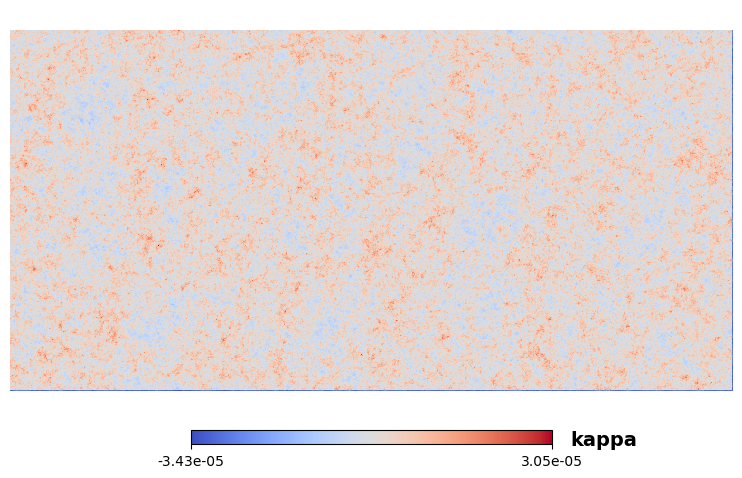

[ 8.98478863e-06 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00]


In [49]:
#hpmap_weight = hp.fitsfunc.read_map('../../FullSky_weight.fits', field=0,nest=False, partial=False, hdu=1, h=False, verbose=True, memmap=True)

#show mask:
#hp.mollview(hpmap_weight,
#            unit=None, cmap=pl.cm.coolwarm,
#            cbar=True, title='weight', norm=None
#            , nest=False
#            )
#pl.show()
#print(hpmap_weight)

#hp.mollview(kpmap,
#            unit='kappa', cmap=pl.cm.coolwarm,
#            cbar=True, title='', norm=None
#            , nest=False
#            )
#pl.show()
#print(kpmap)


hp.cartview(kpmap_ring,
            cbar=True, lonra=lonra, latra=latra,
            nest=False,
            title=" ",
            # min=-10, max=0,
            cmap=pl.cm.coolwarm,
            norm=None, unit='kappa')
pl.show()
print(kpmap_ring)


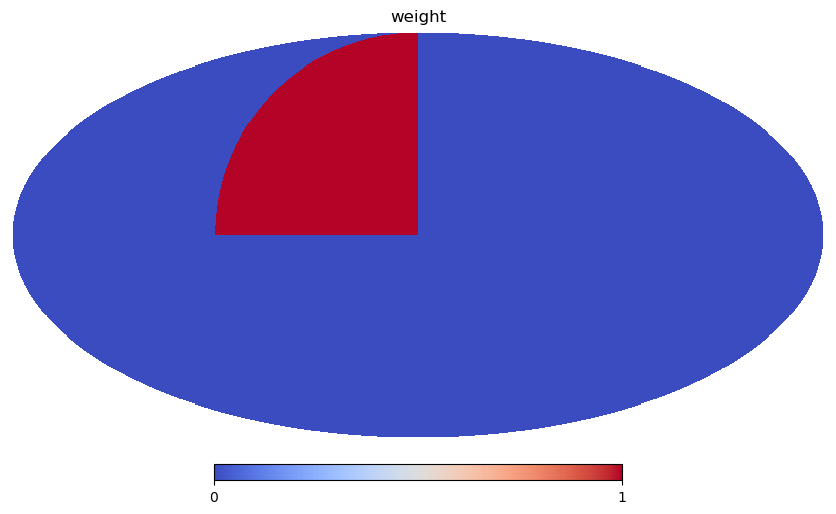

setting the output map dtype to [dtype('float64')]


In [33]:
#Construct mask with correct NSIDE & quadrant:
#a = healsparse.HealSparseMap.read(os.path.join(path, filename))
#mask = a.generate_healpix_map()

# turn masked pixels to zero.
#mask[mask>-1.0e+30]=1
#mask[mask<-1.0e+30]=0

#hp.mollview(mask,
#            unit=None, cmap=pl.cm.coolwarm,
#            cbar=True, title='weight', norm=None
#            , nest=False
#            )
#pl.show()
#hp.fitsfunc.write_map('../../FullSky_weight_4096.fits',mask,nest=False,overwrite=True)


In [34]:
#del hpmap_weight

In [18]:
# Mass2Kappa_n(z) using SimulLens code:
nside = 8192
npix = 12 * nside**2
noct = npix / 8 - nside
zs=57

input_dir = input.baseDirectory
mapsNames = sorted(directory_contents)[58:1:-1] # use this one when there is a README file in the directory.
#mapsNames = sorted(directory_contents)[57:0:-1]

mapsNames = np.array(mapsNames)
#print("Found these maps in the directory:", mapsNames)
#print("For a total of ",np.shape(mapsNames), "Maps")
#print("*****")
nl = np.shape(mapsNames)[0]
Norm = 1.0

for tomo in range(1,6):

    print('*** Working on tomo' , tomo, '***')
    
    #----
    # Read the n(z) files
    zs,Nz = np.loadtxt("./Euclid_dndz_fu08_bin1-5.dat",comments='#',usecols=(0,tomo),unpack=True)
    #Nz_normal = Nz/total_area(zs,Nz)
    nzbins = np.shape(zs)[0]

    #----
    # compute the Jacobian, dchi/dz:
    chi_file = np.zeros(nzbins)
    for i in range(0,nzbins):
        chi_file[i] = ncosmo.comoving_distance(zs[i]).value*ncosmo.h
        #print(i,zs[i], chi_file[i])

    #----
    # compute the dchi:
    dchi = np.zeros(nzbins)
    for i in range(0,nzbins-1):
        dchi[i] = chi_file[i+1]-chi_file[i]

    dchi[nzbins-1] = dchi[nzbins-2]


    # Initialise kappa maps:
    kpmap = np.zeros(npix)

    #Loop over the lenses:
    zid=0
    for filename in mapsNames:
        #tmp = filename.split('_')
        #zid = int(tmp[4][:-4])
        #zl = zl_list[zid]
        #zl=dllen[zid, 0]
        #zl=zlens_exact[28-zid]
        zl=zlens_exact[56-zid]
        chi_l = ncosmo.comoving_distance(zl).value*ncosmo.h

        zid+=1

        #find minimum for the Nz integration
        zmin = 0
        for ii in range(0,nzbins):
            if(zs[ii] > zl):
                zmin = ii
                break

        # Get integal over sources
        gw = 0
        for ii in range(zmin, nzbins):
            gw = gw + Nz[ii]*(1.0 - chi_l/chi_file[ii])*dchi[ii]     


        #-----
        # Get Kernel
        kernel = 3./2. * Om0 * (3000/10240)/(3e3**2)*chi_l * (1+zl) * gw * Norm
        #print('Kernel4 = ', kernel)

        #print(zl, zmin, zs[zmin], Nz[zmin], gw, kernel, filename)

        # Get particle_count planes:
        massmap = np.fromfile(input.baseDirectory+filename, dtype="<f")
        
        #Convert to mass planes, in M_sun/h
        #massmap *= mp 

        #Convert to overdensity maps, 
        massmap-=np.mean(massmap)*8

        # Integrate:
        #kpmap = kpmap + massmap*kernel

    continue    
        
    # Convert to ring-ordered for sph.harmonic transforms:
    kpmap_ring = hp.reorder(kpmap, n2r = True)
    print("reordered map")

    #Apply mask
    if 'hpmap_weight' in locals():
        print("Mask already defined!")
    else:
        print("Reading in weight map for Mira Titan (Comment if already on disk...)")
        hpmap_weight = hp.fitsfunc.read_map('../../FullSky_weight.fits', field=0,nest=False, partial=False, hdu=1, h=False, verbose=True, memmap=True)


    kpmap_ring *= hpmap_weight
    print("applied mask")

    
    # show kappa:
    hp.mollview(kpmap_ring,
                unit='kappa', cmap=pl.cm.coolwarm,
                cbar=True, title='', norm=None
                , nest=False
                )
    pl.show()

    lonra = [0, 20]
    latra = [0, 10]

    hp.cartview(kpmap_ring,
                cbar=True, lonra=lonra, latra=latra,
                nest=False,
                title=" ",
                # min=-10, max=0,
                cmap=pl.cm.coolwarm,
                norm=None, unit='kappa')
    pl.show()
    
    
    fname = "../../kappa/V0/kappa_tomo"+np.str(tomo)+"_V3" 

    np.save(fname, kpmap_ring)
    print("Saved kappa")




*** Working on tomo 1 ***
0.018746 2 0.025 0.043675671 141.11194283902205 0.00010406845095241647 density_map_487_dens.bin
0.040929 4 0.045 0.057694448 123.3921761241848 0.00020209992099076197 density_map_475_dens.bin
0.063221 6 0.065 0.068766169 107.71728966723832 0.00027707844367207054 density_map_464_dens.bin
0.089164 9 0.095 0.082640752 91.61479306579602 0.0003386290497717983 density_map_453_dens.bin
0.115479 12 0.125 0.094688125 77.17816275020085 0.00037627555652623 density_map_442_dens.bin
0.141379 14 0.145 0.10210442 64.6545396724474 0.00039267633430662763 density_map_432_dens.bin
0.170235 17 0.175 0.11263836 52.37970798008667 0.00039026793411244253 density_map_421_dens.bin
0.198763 20 0.205 0.12271404 41.82450513255839 0.00037036205899014117 density_map_411_dens.bin
0.22817 23 0.235 0.13252069 32.43941300056939 0.0003356159671384345 density_map_401_dens.bin
0.257155 26 0.265 0.14218409 24.549334652000578 0.00029107666527017394 density_map_392_dens.bin
0.287749 29 0.295 0.1517865

In [ ]:
# Compute C_ell:
Cl = hp.sphtfunc.anafast(kpmap_ring, map2=None, nspec=None, lmax=5000, mmax=None, iter=1, alm=False, pol=False, use_weights=False, datapath=None, gal_cut=0, use_pixel_weights=False)
Cl *= 8.0
print("Got C_ell")
#fname = "../../kappa/V0/Cl_tomo"+np.str(tomo)+".dat"
fname = "../../kappa/V0/Cl_tomo"+np.str(tomo)+"_V3.dat"
np.savetxt(fname,Cl)
print("Saved C_ell")



In [7]:
input_dir = input.baseDirectory
mapsNames = sorted(directory_contents)[58:1:-1] # use this one when there is a README file in the directory.
#mapsNames = sorted(directory_contents)[57:0:-1]

mapsNames = np.array(mapsNames)

zid=0
for filename in mapsNames:
    #tmp = filename.split('_')
    #zid = int(tmp[4][:-4])
    #zl = zl_list[zid]
    #zl=dllen[zid, 0]
    #zl=zlens_exact[28-zid]
    zl=zlens_exact[56-zid]
    chi_l = ncosmo.comoving_distance(zl).value*ncosmo.h

    zid+=1

    #find minimum for the Nz integration
    zmin = 0
    for ii in range(0,nzbins):
        if(zs[ii] > zl):
            zmin = ii
            break

    # Get integal over sources
    gw = 0
    for ii in range(zmin, nzbins):
        gw = gw + Nz[ii]*(1.0 - chi_l/chi_file[ii])*dchi[ii]     

    print(zl, zmin, zs[zmin], Nz[zmin], gw)


NameError: name 'nzbins' is not defined

array([1.00000000e-03, 1.08733567e-03, 1.18229887e-03, 1.28555573e-03,
       1.39783061e-03, 1.51991108e-03, 1.65265354e-03, 1.79698915e-03,
       1.95393040e-03, 2.12457823e-03, 2.31012970e-03, 2.51188643e-03,
       2.73126372e-03, 2.96980048e-03, 3.22917000e-03, 3.51119173e-03,
       3.81784403e-03, 4.15127800e-03, 4.51383266e-03, 4.90805127e-03,
       5.33669923e-03, 5.80278345e-03, 6.30957344e-03, 6.86062429e-03,
       7.45980152e-03, 8.11130831e-03, 8.81971488e-03, 9.58999061e-03,
       1.04275389e-02, 1.13382350e-02, 1.23284674e-02, 1.34051824e-02,
       1.45759330e-02, 1.58489319e-02, 1.72331091e-02, 1.87381742e-02,
       2.03746853e-02, 2.21541221e-02, 2.40889673e-02, 2.61927934e-02,
       2.84803587e-02, 3.09677100e-02, 3.36722958e-02, 3.66130884e-02,
       3.98107171e-02, 4.32876128e-02, 4.70681656e-02, 5.11788955e-02,
       5.56486388e-02, 6.05087501e-02, 6.57933225e-02, 7.15394265e-02,
       7.77873705e-02, 8.45809828e-02, 9.19679199e-02, 1.00000000e-01,
      